# Project: Semantic Textual Similarity




### Mandatory project

https://gebakx.github.io/ihlt/sts/index.html#5

**Statement:**

- Use data set and description of task Semantic Textual Similarity in SemEval 2012.

- Implement some approaches to detect paraphrase using sentence similarity metrics.

  - Explore some lexical dimensions.
  - Explore the syntactic dimension alone.
  - Explore the combination of both previous.

- Add new components at your choice (optional)

- Compare and comment the results achieved by these approaches among them and among the official results.

- Send files to raco in IHLT STS Project before the oral presentation:

  - Jupyter notebook: sts-[Student1]-[Student2].ipynb

  - Slides: sts-[Student1]-[Student2].pdf


## Download repository

In [0]:
!git clone https://github.com/gusseppe/master_artificial_intelligence
!cp -r /content/master_artificial_intelligence/Introduction_to_Human_Language_Technology/deliverables/project/* .

## Install requirements

In [3]:
!head -n 10 requirements.txt

numpy
pandas
tarfile
pytorch
nltk
xgboost
hyperopt
sklearn
hpsklearn
auto-sklearn


In [0]:
# !pip install -r requirements.txt

## Third Requirements libraries

In [0]:
import tarfile
import nltk
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import csv
import tensorflow as tf
import seaborn as sns

from nltk import CFG, ChartParser
from nltk.book import FreqDist
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from scipy.stats import pearsonr
from nltk.wsd import lesk
from nltk.corpus import wordnet_ic
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
from nltk.corpus import wordnet as wn
from scipy import spatial
from sklearn.preprocessing import StandardScaler

nltk.download('wordnet')
nltk.download('maxent_ne_chunker')
nltk.download('conll2000')


## Download models

These models will be usefull for mapping words into real vectors. Instead of calculating cosine distance after applying some methods (lcs distance, wsd, depency trees, etc.), embeddings will take place. Models:

- Fast word2vec
- Inferset facebook


First, download Fast word2vec and unzip:

https://fasttext.cc/docs/en/english-vectors.html

Second, download Inferset (model 2) and unzip:

https://drive.google.com/file/d/1sfIlbc8C5k_CujTF7UrtW_2lvNIH-EhW/view?usp=sharing



References:

- Snippet: https://github.com/facebookresearch/InferSent/blob/master/demo.ipynb


## Load models

Once downloaded the required files, put those models in 'models_repo' folder.


1. Load Inferset model (custom model).
2. Load fasttext word2vec embedding parsing.


In [0]:
%%time

# !curl -Lo models/glove.840B.300d.zip http://nlp.stanford.edu/data/glove.840B.300d.zip

from infersent import InferSent

model_version = 2
MODEL_PATH = f'./models_repo/infersent{model_version}.pkl'
# W2V_PATH = './models_repo/glove.840B.300d.txt' # GloVe
W2V_PATH = './models_repo/crawl-300d-2M.vec' # fastText
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}

model_senteval = InferSent(params_model)
model_senteval.load_state_dict(torch.load(MODEL_PATH))
model_senteval.set_w2v_path(W2V_PATH)
model_senteval.build_vocab_k_words(K=100000)

Vocab size : 100000
CPU times: user 4.94 s, sys: 552 ms, total: 5.5 s
Wall time: 5.6 s


# Exploratory Data Analysis

## Download train/test sets


In [0]:
url_train = 'https://www.cs.york.ac.uk/semeval-2012/task6/data/uploads/datasets/train.tgz'
url_test = 'https://www.cs.york.ac.uk/semeval-2012/task6/data/uploads/datasets/test-gold.tgz'

!wget -q $url_train
!wget -q $url_test

with tarfile.open('train.tgz', "r:gz") as tar:
  tar.extractall()
with tarfile.open('test-gold.tgz', "r:gz") as tar:
  tar.extractall()

!echo 'Training' && ls train && echo '\nTesting' && ls test-gold

Training
00-readme.txt	   STS.gs.MSRvid.txt	   STS.input.MSRvid.txt
correlation.pl	   STS.gs.SMTeuroparl.txt  STS.input.SMTeuroparl.txt
STS.gs.MSRpar.txt  STS.input.MSRpar.txt    STS.output.MSRpar.txt
\nTesting
00-readme.txt	   STS.gs.SMTeuroparl.txt	STS.input.MSRvid.txt
STS.gs.ALL.txt	   STS.gs.surprise.OnWN.txt	STS.input.SMTeuroparl.txt
STS.gs.MSRpar.txt  STS.gs.surprise.SMTnews.txt	STS.input.surprise.OnWN.txt
STS.gs.MSRvid.txt  STS.input.MSRpar.txt		STS.input.surprise.SMTnews.txt


## Read and gather metadata

Let's begin working with **MSRvid** data set

Let's load all the training data.

In [23]:
# Training data
fnames_train = ['MSRpar', 'MSRvid', 
             'SMTeuroparl']
_train_sents = [pd.read_csv(f'train/STS.input.{f}.txt',
                           sep='\t', quoting=csv.QUOTE_NONE,
                           names=['sent1', 'sent2']) for f in fnames_train]
train_sents = pd.concat(_train_sents, axis=0, ignore_index=True)
_train_label = [pd.read_csv(f'train/STS.gs.{f}.txt',
                           names=['score']) for f in fnames_train]
train_label = pd.concat(_train_label, axis=0, ignore_index=True)
train_data = pd.concat([train_sents, train_label], axis=1)

# Testing data
fnames_test = fnames_train + ['surprise.OnWN', 'surprise.SMTnews']
_test_sents = [pd.read_csv(f'test-gold/STS.input.{f}.txt',
                           sep='\t', quoting=csv.QUOTE_NONE,
                           names=['sent1', 'sent2']) for f in fnames_test]
test_sents = pd.concat(_test_sents, axis=0, ignore_index=True)
_test_label = [pd.read_csv(f'test-gold/STS.gs.{f}.txt',
                           names=['score']) for f in fnames_test]
test_label = pd.concat(_test_label, axis=0, ignore_index=True)
test_data = pd.concat([test_sents, test_label], axis=1)


print(f' Train data set: ({len(train_data)}, {len(train_data.columns)})')
train_data.head()


 Train data set: (2234, 3)


,sent1,sent2,score
0,But other sources close to the sale said Viven...,But other sources close to the sale said Viven...,4.00
1,Micron has declared its first quarterly profit...,Micron's numbers also marked the first quarter...,3.75
2,The fines are part of failed Republican effort...,"Perry said he backs the Senate's efforts, incl...",2.80
3,"The American Anglican Council, which represent...","The American Anglican Council, which represent...",3.40
4,The tech-loaded Nasdaq composite rose 20.96 po...,The technology-laced Nasdaq Composite Index <....,2.40


In [5]:
print(f' Test data set: ({len(test_data)}, {len(test_data.columns)})')
test_data.head()


 Test data set: (3108, 3)


,sent1,sent2,score
0,The problem likely will mean corrective change...,He said the problem needs to be corrected befo...,4.4
1,The technology-laced Nasdaq Composite Index .I...,The broad Standard & Poor's 500 Index .SPX inc...,0.8
2,"""It's a huge black eye,"" said publisher Arthur...","""It's a huge black eye,"" Arthur Sulzberger, th...",3.6
3,SEC Chairman William Donaldson said there is a...,"""I think there's a building confidence that th...",3.4
4,Vivendi shares closed 1.9 percent at 15.80 eur...,"In New York, Vivendi shares were 1.4 percent d...",1.4


**Check frequency of tokens**

As shown in the result we should deal with stopwords as well as punctuations.


In [0]:
sent1_tokens = train_data['sent1'].apply(nltk.word_tokenize).values
sent2_tokens = train_data['sent2'].apply(nltk.word_tokenize).values

freq_sent1 = FreqDist(np.concatenate(sent1_tokens).ravel())
freq_sent2 = FreqDist(np.concatenate(sent2_tokens).ravel())

print(f'Sentence 1:')
print(freq_sent1.most_common()[:6])

print(f'Sentence 2:')
print(freq_sent2.most_common()[:6])

Sentence 1:
[('the', 2297), ('.', 2209), (',', 1828), ('of', 1250), ('a', 1216), ('to', 1065)]
Sentence 2:
[('the', 2501), ('.', 2227), (',', 1868), ('of', 1322), ('a', 1181), ('to', 1116)]


In [0]:
train_data.dtypes

sent1     object
sent2     object
score    float64
dtype: object

## Preprocessing

- Cast sentences as type string.
- Deal with stopwords and puntuations.
- Tokenize the sentences.
- Tag each word as a Part of speech (POS).
- Lemmatize each word into its root but with sense (different than stemming).
- Extract WordNet synsets, if necessary.


**Casting**



In [0]:
# train_data[['sent1', 'sent2']] = train_data[['sent1', 'sent2']].astype(str) 
# print(train_data.dtypes)


**Stopwords and puntuations**

In [6]:
# stopwords and punctuations

def get_stopwords():
  stop_words = list(set(stopwords.words('english')))
  stop_words_2 = [w.capitalize() for w in stop_words]
  stop_words_3 = [w.upper() for w in stop_words]

  stop_words_all = stop_words + stop_words_2 + stop_words_3

  return stop_words_all

def remove_stopwords(tokens, rm_punct=False, custom_chars=None):
  
  stop_words_all = get_stopwords()
  result = [w for w in tokens if w not in stop_words_all]

  if rm_punct:
    result = [w for w in result if w not in punctuation]

  if custom_chars is not None:  # custom characters to remove
    result = [w for w in result if w not in custom_chars]

  return result

# Test
s1 = 'A man is riding a bicycle.'
remove_stopwords(nltk.word_tokenize(s1), rm_punct=True)

['man', 'riding', 'bicycle']

**POS**



In [0]:
#
# Map Treebank tag prefix to WordNet tag
#
def map_pos_wordnet(pos):
  d = {"N": wordnet.NOUN, # 'n'
       "V": wordnet.VERB, # 'v'
       "J": wordnet.ADJ, #  'a'
       "R": wordnet.ADV} #  'r'

  return d[pos[0]]

#
# Lemmatize
#
def lemmatize(pairs):
  wnl = WordNetLemmatizer()
  result = []
  for token, pos in pairs:
    if pos[0] in {'N','V', 'J', 'R'}:
      synset = wnl.lemmatize(token.lower(), 
                                     pos=map_pos_wordnet(pos))
      result.append(synset)
    else:
      result.append(token)
  return result

In [8]:
def join_tokens(tokens):
  return ' '.join(tokens)

join_tokens(['a', 'b'])

'a b'

**Embeddings**


In [0]:
def get_score_infersent(X, tokenize=True):
    eb1 = model_senteval.encode([X[0]], tokenize=tokenize)
    eb2 = model_senteval.encode([X[1]], tokenize=tokenize)

    result = 1 - spatial.distance.cosine(eb1,eb2)

    return result

**WordNet synsets**

In [0]:
#
# Get list of synsets for given list of token-pos-pairs
#
def get_wordnet_synsets(X):
    results = []
    for x in X:
        (token, pos) = x
        result = []
        
        # Try for usual PoS tags in Wordnet
        if pos[0] in {'N','V', 'J', 'R'}:
            synset = wn.synsets(token.lower(), pos=map_pos_wordnet(pos))
          
        # Else discard PoS tag and try to get some available synset
        else:
            synset = wn.synsets(token.lower())

        # Use the best found synset
        if len(synset):
            results.append(synset[0])

        # If not found, then try to cleanup the word and try again (without PoS tag)
        else:
            clean_token = token.lower().translate(str.maketrans('', '', punctuation))
            synset = wn.synsets(clean_token)

            if len(synset):
                results.append(synset[0])

            # If nothing helps, then use default synset value as neutral element and placeholder
            else:
                results.append(wn.synsets('default')[0])
        
    return results

## Feature engineering

Extract the most meaningful features from the sentences

In [0]:
cols = ['sent1_processed', 'sent2_processed']

### Synset based distance metrics

Compute multiple measures based on similarities of lemma synsets. Use *greedy* approach to align most similar lemmas using different similarity metrics:

- Path similarity
- Leacock & Chodorow (normalized)
- Wu & Palmer
- Lin

When quering synsets for single lemmas, not all synsets can be found, e.g. if lemma has PoS tag *n* and such do not exist for matching synset. For these cases, synset query is conducted without PoS tag to get at least some result. If even this does not help, then default synset is used.

Also when computing distances, an alignment of most similar synsets is done pair-wise. Mathing lemmas are then removed and do not considered in further alignment process. However, if sentences have different length, then there will be some lemmas in longer sentece left without any match in shorter sentence. In this case rest of lemmas are paired with default synset, so that their similarity is set to 0.



**Apply preprocessing steps**


In [0]:
%%time
#
# Preprocessing sentences and generating lemmas, PoS tags and synsets
# 
def preprocess_data_synsets(data):
  for col in ['sent1', 'sent2']:
    col_p = col+'_processed'
    data[col_p] = data[col].apply(nltk.word_tokenize)
    data[col_p] = data[col_p].apply(remove_stopwords, rm_punct=True)
    data[col_p] = data[col_p].apply(nltk.pos_tag)
    data[col_p] = data[col_p].apply(lemmatize)
    data[col_p] = data[col_p].apply(nltk.pos_tag)
    # data[col_p] = data[col_p].apply(join_tokens)
    # data[col_p] = data[col_p].apply(core_relationship)

    # Compute synsets for every sentence with best choices and add to dataset as extra columns
    data[col_p] = data[col_p].apply(get_wordnet_synsets)
    

# Apply preprocessing to training data
preprocess_data_synsets(train_data)  
train_data.head(2)

CPU times: user 7.52 s, sys: 104 ms, total: 7.62 s
Wall time: 7.75 s


,sent1,sent2,score,sent1_processed,sent2_processed
0,But other sources close to the sale said Viven...,But other sources close to the sale said Viven...,4.00,"[Synset('beginning.n.04'), Synset('close.a.01'...","[Synset('beginning.n.04'), Synset('close.a.01'..."
1,Micron has declared its first quarterly profit...,Micron's numbers also marked the first quarter...,3.75,"[Synset('micron.n.01'), Synset('declare.v.01')...","[Synset('micron.n.01'), Synset('second.n.01'),..."


In [0]:
%%time
brown_ic = wordnet_ic.ic('ic-brown.dat')

# Lambdas for similarity measures
similarity_lin = lambda syn1, syn2: syn1.lin_similarity(syn2, ic=brown_ic)
similarity_lch = lambda syn1, syn2: syn1.lch_similarity(syn2) / syn1.lch_similarity(syn1)
similarity_wup = lambda syn1, syn2: syn1.wup_similarity(syn2)
similarity_ps = lambda syn1, syn2: syn1.path_similarity(syn2)

# Greedily find best synset pairs from two sentences and compute the average similarity
def greedy_avg_alignment_similarity(synsets, sim_f):
    
    # Use shorter list as first one
    if (len(synsets[0]) <= len(synsets[1])):
        synsets1 = synsets[0].copy()
        synsets2 = synsets[1].copy()
    else:
        synsets1 = synsets[1].copy()
        synsets2 = synsets[0].copy()
    
    # Collect best similarities comparing synsents from shorter list to longer list  
    sims = []
    for syn1 in synsets1:
        best_sim = 0
        best_syn2 = None
        
        # Find best similarity in second set
        for syn2 in synsets2:
            # Get similarity
            try:
                sim = sim_f(syn1, syn2)
            except:
                sim = 0
            
            # Check if sim = NoneType
            if not sim:
                sim = 0
            
            if sim >= best_sim:
                best_sim = sim
                best_syn2 = syn2

        # Add best pair
        sims.append(best_sim)
                
        # Remove found synset from second list
        synsets2.remove(best_syn2)
        
    # For rest of not aligned lemma pairs use default similarity of 0
    for syn2 in synsets2:
        sims.append(0)
        
    return np.mean(sims)

#
# Add different distance measuares based on synsets from WordNet
#
def add_synset_distance_metrics(data, synsets_cols):
    data['ps'] = data[synsets_cols].apply(lambda x: greedy_avg_alignment_similarity(x, similarity_ps), axis=1)
    data['lch'] = data[synsets_cols].apply(lambda x: greedy_avg_alignment_similarity(x, similarity_lch), axis=1)
    data['wup'] = data[synsets_cols].apply(lambda x: greedy_avg_alignment_similarity(x, similarity_wup), axis=1)
    data['lin'] = data[synsets_cols].apply(lambda x: greedy_avg_alignment_similarity(x, similarity_lin), axis=1)

# Append multiple synset based distances to dataframe
add_synset_distance_metrics(train_data, cols)

# Sample output
train_data.head(2)


CPU times: user 22 s, sys: 309 ms, total: 22.3 s
Wall time: 22.4 s


,sent1,sent2,score,sent1_processed,sent2_processed,ps,lch,wup,lin
0,But other sources close to the sale said Viven...,But other sources close to the sale said Viven...,4.00,"[Synset('beginning.n.04'), Synset('close.a.01'...","[Synset('beginning.n.04'), Synset('close.a.01'...",0.576236,0.478867,0.603125,0.441224
1,Micron has declared its first quarterly profit...,Micron's numbers also marked the first quarter...,3.75,"[Synset('micron.n.01'), Synset('declare.v.01')...","[Synset('micron.n.01'), Synset('second.n.01'),...",0.433333,0.366896,0.444444,0.280471


### Dependency Trees

**Apply preprocessing steps**

In [0]:
from nltk.parse.corenlp import CoreNLPDependencyParser
from nltk.metrics.distance import jaro_similarity, jaro_winkler_similarity

parser = CoreNLPDependencyParser(url='http://localhost:9000')

def dp_relationship(sent):

#   results = []
#   for x in X:
#     result = []

    parse = parser.raw_parse(sent)
    tree = next(parse)
    triples = list(tree.triples())
    # print(triples1)
    core_triples = list()
    for (a,b,c) in triples:
      # if b in ['nsubj']:
      core_triples.append(c)
      core_triples.append(a)
      # if b in ['nmod']:
      #   core_triples1.append(c)
      #   core_triples1.append(a)
      # elif b in ['dobj']:
      #   core_triples1.append(c)
      #   core_triples1.append(a)
    # core_triples1 = [(c, a) for (a,b,c) in triples1 if b in ['nsubj']]
    unique = []
    [unique.append(item) for item in core_triples if item not in unique]

    unique = [item for item in unique if 'V' in item[1] or 'N' in item[1] ]

    return unique


In [0]:
%%time

def preprocess_data_trees(data):
  for col in ['sent1', 'sent2']:
    data[col+'_processed'] = data[col].apply(nltk.word_tokenize)
    data[col+'_processed'] = data[col+'_processed'].apply(remove_stopwords, 
                                                          rm_punct=True)
    data[col+'_processed'] = data[col+'_processed'].apply(join_tokens)
    # data[col+'_processed'] = data[col+'_processed'].apply(nltk.pos_tag)
    data[col+'_processed'] = data[col+'_processed'].apply(dp_relationship)
    data[col+'_processed'] = data[col+'_processed'].apply(lemmatize)
    data[col+'_processed'] = data[col+'_processed'].apply(join_tokens)
    # data[col+'_processed'] = data[col+'_processed'].apply(lemmatize)
    # data[col+'_processed'] = data[col+'_processed'].apply(join_tokens)

preprocess_data_trees(train_data)
train_data.head(3)

CPU times: user 57.1 s, sys: 1.28 s, total: 58.4 s
Wall time: 5min 47s


,sent1,sent2,score,sent1_processed,sent2_processed,ps,lch,wup,lin
0,But other sources close to the sale said Viven...,But other sources close to the sale said Viven...,4.00,sale say source keep vivendi hop bid door see ...,sale say source keep vivendi bid door day,0.576236,0.478867,0.603125,0.441224
1,Micron has declared its first quarterly profit...,Micron's numbers also marked the first quarter...,3.75,micron declare profit year,number mark micron profit year manufacturer dram,0.433333,0.366896,0.444444,0.280471
2,The fines are part of failed Republican effort...,"Perry said he backs the Senate's efforts, incl...",2.80,part fail fine entice force effort return demo...,perry say effort senate back fine include forc...,0.423077,0.371224,0.485209,0.043715


In [0]:
%%time

depen_parsing = train_data[cols].apply(get_score_infersent, axis=1).values
depen_parsing = pd.DataFrame(np.stack(depen_parsing), columns=['dp'])
train_data = pd.concat([train_data, depen_parsing], axis=1)
train_data.head(2)

CPU times: user 4.62 ms, sys: 0 ns, total: 4.62 ms
Wall time: 5.11 ms


,sent1,sent2,score,sent1_processed,sent2_processed,ps,lch,wup,lin,dp
0,But other sources close to the sale said Viven...,But other sources close to the sale said Viven...,4.00,sale say source keep vivendi hop bid door see ...,sale say source keep vivendi bid door day,0.576236,0.478867,0.603125,0.441224,0.944957
1,Micron has declared its first quarterly profit...,Micron's numbers also marked the first quarter...,3.75,micron declare profit year,number mark micron profit year manufacturer dram,0.433333,0.366896,0.444444,0.280471,0.916931


### SentEval: sentence embeddings

This function yields a score from  a pretrained model, based on word embedding.




In [0]:
def preprocess_data_sentevel(data):
  for col in ['sent1', 'sent2']:
    data[col+'_processed'] = data[col].apply(nltk.word_tokenize)
    data[col+'_processed'] = data[col+'_processed'].apply(remove_stopwords, 
                                                          rm_punct=True)
    data[col+'_processed'] = data[col+'_processed'].apply(nltk.pos_tag)
    data[col+'_processed'] = data[col+'_processed'].apply(lemmatize)
    data[col+'_processed'] = data[col+'_processed'].apply(join_tokens)

preprocess_data_sentevel(train_data)
train_data.head(3)

,sent1,sent2,score,sent1_processed,sent2_processed,ps,lch,wup,lin,dp
0,But other sources close to the sale said Viven...,But other sources close to the sale said Viven...,4.00,source close sale say vivendi keep door open b...,source close sale say vivendi keep door open b...,0.576236,0.478867,0.603125,0.441224,0.944957
1,Micron has declared its first quarterly profit...,Micron's numbers also marked the first quarter...,3.75,micron declare first quarterly profit three year,micron 's number also mark first quarterly pro...,0.433333,0.366896,0.444444,0.280471,0.916931
2,The fines are part of failed Republican effort...,"Perry said he backs the Senate's efforts, incl...",2.80,fine part fail republican effort force entice ...,perry say back senate 's effort include fine f...,0.423077,0.371224,0.485209,0.043715,0.939007


In [0]:
%%time

infer_feat = train_data[cols].apply(get_score_infersent, axis=1)
infer_feat = pd.DataFrame(np.stack(infer_feat), columns=['infer'])
train_data = pd.concat([train_data, infer_feat], axis=1)
train_data.head(2)


CPU times: user 9min 48s, sys: 299 ms, total: 9min 48s
Wall time: 9min 48s


,sent1,sent2,score,sent1_processed,sent2_processed,ps,lch,wup,lin,dp,infer
0,But other sources close to the sale said Viven...,But other sources close to the sale said Viven...,4.00,source close sale say vivendi keep door open b...,source close sale say vivendi keep door open b...,0.576236,0.478867,0.603125,0.441224,0.944957,0.958609
1,Micron has declared its first quarterly profit...,Micron's numbers also marked the first quarter...,3.75,micron declare first quarterly profit three year,micron 's number also mark first quarterly pro...,0.433333,0.366896,0.444444,0.280471,0.916931,0.946287


### Overlapping

Count how many words appears from one sentence to the other.




In [0]:
def preprocess_count_overlap(data):
  for col in ['sent1', 'sent2']:
    data[col+'_processed'] = data[col].apply(nltk.word_tokenize)
    data[col+'_processed'] = data[col+'_processed'].apply(remove_stopwords, 
                                                          rm_punct=True)
    data[col+'_processed'] = data[col+'_processed'].apply(nltk.pos_tag)
    data[col+'_processed'] = data[col+'_processed'].apply(lemmatize)
    data[col+'_processed'] = data[col+'_processed'].apply(join_tokens)


preprocess_count_overlap(train_data)


def count_overlap(X):
  words1 = X[0].strip().split()
  words2 = X[1].strip().split()

  counter = 0
  for w in words1:
    counter += words2.count(w)

  score = 2*counter / (len(words1) + len(words2))

  return score


In [0]:
%%time

overlap_feat = train_data[cols].apply(count_overlap, axis=1)
overlap_feat = pd.DataFrame(np.stack(overlap_feat), columns=['over'])
train_data = pd.concat([train_data, overlap_feat], axis=1)
train_data.head(2)


CPU times: user 140 ms, sys: 0 ns, total: 140 ms
Wall time: 183 ms


,sent1,sent2,score,sent1_processed,sent2_processed,ps,lch,wup,lin,dp,infer,over
0,But other sources close to the sale said Viven...,But other sources close to the sale said Viven...,4.00,source close sale say vivendi keep door open b...,source close sale say vivendi keep door open b...,0.576236,0.478867,0.603125,0.441224,0.944957,0.958609,0.642857
1,Micron has declared its first quarterly profit...,Micron's numbers also marked the first quarter...,3.75,micron declare first quarterly profit three year,micron 's number also mark first quarterly pro...,0.433333,0.366896,0.444444,0.280471,0.916931,0.946287,0.631579


### Universal encoder

This is similar to inferset. So, can be used for text similarity problems.


https://arxiv.org/abs/1803.11175



In [13]:
%%time

from absl import logging

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
model = hub.load(module_url)
print ("module %s loaded" % module_url)

def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded
CPU times: user 5.22 s, sys: 1.27 s, total: 6.49 s
Wall time: 6.66 s


In [24]:
%%time

def preprocess_uni_encoder(data):
  for col in ['sent1', 'sent2']:
    data[col+'_processed'] = data[col].apply(nltk.word_tokenize)
    data[col+'_processed'] = data[col+'_processed'].apply(remove_stopwords, 
                                                          rm_punct=True)
    data[col+'_processed'] = data[col+'_processed'].apply(nltk.pos_tag)
    data[col+'_processed'] = data[col+'_processed'].apply(lemmatize)
    data[col+'_processed'] = data[col+'_processed'].apply(join_tokens)


def get_score_univer_encoder(X):
  sts_encode1 = tf.nn.l2_normalize(embed(tf.constant(X['sent1_processed'].tolist())), axis=1)
  sts_encode2 = tf.nn.l2_normalize(embed(tf.constant(X['sent2_processed'].tolist())), axis=1)
  cosine_similarities = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)
  clip_cosine_similarities = tf.clip_by_value(cosine_similarities, -1.0, 1.0)
  scores = 1.0 - tf.acos(clip_cosine_similarities)

  return scores

preprocess_uni_encoder(train_data)

CPU times: user 4.18 s, sys: 67.5 ms, total: 4.25 s
Wall time: 4.29 s


In [0]:
# train_data = pd.concat([train_data, X_load_train], axis=1)
# train_data.head()

In [28]:
%%time

uniencoder_feat = get_score_univer_encoder(train_data)
uniencoder_feat = pd.DataFrame(np.stack(uniencoder_feat), columns=['uni'])
train_data = pd.concat([train_data, uniencoder_feat], axis=1)
train_data.head(2)

CPU times: user 815 ms, sys: 99.2 ms, total: 914 ms
Wall time: 588 ms


,sent1,sent2,score,sent1_processed,sent2_processed,ps,lch,wup,lin,dp,infer,over,uni
0,But other sources close to the sale said Viven...,But other sources close to the sale said Viven...,4.00,source close sale say vivendi keep door open b...,source close sale say vivendi keep door open b...,0.576236,0.478867,0.603125,0.441224,0.944957,0.958609,0.642857,0.308706
1,Micron has declared its first quarterly profit...,Micron's numbers also marked the first quarter...,3.75,micron declare first quarterly profit three year,micron 's number also mark first quarterly pro...,0.433333,0.366896,0.444444,0.280471,0.916931,0.946287,0.631579,0.121527


# Modeling

Try a baseline model with the final features: basically the join of the scores (from dependency tree, wds, lcs, etc).







In [29]:
train_data.head(2)

,sent1,sent2,score,sent1_processed,sent2_processed,ps,lch,wup,lin,dp,infer,over,uni
0,But other sources close to the sale said Viven...,But other sources close to the sale said Viven...,4.00,source close sale say vivendi keep door open b...,source close sale say vivendi keep door open b...,0.576236,0.478867,0.603125,0.441224,0.944957,0.958609,0.642857,0.308706
1,Micron has declared its first quarterly profit...,Micron's numbers also marked the first quarter...,3.75,micron declare first quarterly profit three year,micron 's number also mark first quarterly pro...,0.433333,0.366896,0.444444,0.280471,0.916931,0.946287,0.631579,0.121527


In [30]:
label = 'score'
features = [col for col in train_data.columns if col not in ['sent1',
                                                             'sent2',
                                                             'sent1_processed',
                                                             'sent2_processed', label]]
X = train_data[features].copy()
y = train_data[label].copy()
X.head()

,ps,lch,wup,lin,dp,infer,over,uni
0,0.576236,0.478867,0.603125,0.441224,0.944957,0.958609,0.642857,0.308706
1,0.433333,0.366896,0.444444,0.280471,0.916931,0.946287,0.631579,0.121527
2,0.423077,0.371224,0.485209,0.043715,0.939007,0.938343,0.500000,0.044599
3,0.622222,0.355331,0.638889,0.333333,0.950514,0.964189,0.733333,0.394504
4,0.621759,0.593266,0.727564,0.465101,0.879717,0.913712,0.260870,0.143134


Save training features and label

In [0]:
X_y = pd.concat([X, y], axis=1)
X_y.to_csv('train_features.csv', index=False)

Scaling all the features with mean 0 and  variance 1



In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X) # This scaler will be used for testing stage too

X_scaled = scaler.transform(X)
X_scaled

array([[ 0.50869582,  0.08256956,  0.27500424, ...,  0.36778079,
         0.32854469,  0.43621894],
       [-0.16624555, -0.55401826, -0.59293359, ..., -0.00341259,
         0.28332649, -0.22728767],
       [-0.21468735, -0.52941227, -0.36996169, ..., -0.2427314 ,
        -0.24421923, -0.49997777],
       ...,
       [ 2.51016403,  0.20271383,  2.44579842, ...,  1.61466474,
         1.7604545 ,  2.88669451],
       [ 0.18625694,  0.24130234,  0.31719527, ...,  0.693956  ,
         0.61492665,  0.43401334],
       [-2.04891601, -1.89756609, -2.51533142, ..., -0.73282645,
        -1.10336511, -1.06938439]])

In [230]:
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

test_size = 0.2
seed = 41
X_train, X_val, y_train, y_val = train_test_split(
                X_scaled, y, test_size=test_size, random_state=seed)

X_train

array([[ 2.51016403,  3.04533838,  2.18533568, ...,  1.25478875,
         0.42400535,  1.25529431],
       [-0.30509523, -0.14431314, -0.42490958, ...,  0.60539561,
         0.42400535,  0.36418973],
       [ 1.25067717, -0.18954768,  0.98720706, ...,  0.74216845,
         1.14363181,  1.09803442],
       ...,
       [-0.46362439,  0.00556136, -0.28906039, ..., -0.47868713,
        -0.64515397, -1.55810484],
       [-0.2025769 ,  0.87059663,  0.42721216, ..., -1.5349244 ,
        -0.9124438 , -1.05280954],
       [ 0.19782487, -0.62808658, -0.10259274, ..., -0.02334505,
         0.52680913,  0.08621477]])

In [0]:
# !pip install xgboost

**XGBoost**

In [231]:
%%time

from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor

from xgboost import XGBRegressor

estimator_xgboost = XGBRegressor(seed=seed)

estimator_xgboost.fit(X_train, y_train)
print(f'[+] Validation score: {estimator_xgboost.score(X_val, y_val)}')

# Train will all training data
estimator_xgboost.fit(X_scaled, y.values)

/home/guess/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:19:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[+] Validation score: 0.6936367145905857
[16:19:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 415 ms, sys: 118 µs, total: 415 ms
Wall time: 466 ms


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=41, silent=None,
       subsample=1, verbosity=1)

LightGBM

In [232]:
%%time

# from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor

estimator_lightgbm = LGBMRegressor(seed=seed)

estimator_lightgbm.fit(X_train, y_train)
print(f'[+] Validation score: {estimator_lightgbm.score(X_val, y_val)}')

# Train will all training data
estimator_lightgbm.fit(X_scaled, y.values)


[+] Validation score: 0.7063171902551468
CPU times: user 486 ms, sys: 8.14 ms, total: 495 ms
Wall time: 577 ms


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=41,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0)

## Tuning

Search the best hyperparameters for both XGboost and  Lightgbm.


Adapted from:


https://github.com/dawidkopczyk/blog/blob/master/hyperparam.py

References for hyperparameters:

https://lightgbm.readthedocs.io/en/latest/Parameters.html

https://xgboost.readthedocs.io/en/latest/parameter.html

In [0]:
# !pip install hyperopt

In [264]:
%%time

from functools import partial
from hyperopt import fmin, hp, tpe, Trials, space_eval
from sklearn.model_selection import (cross_val_score, train_test_split)
from sklearn.metrics import r2_score
 
# Define search space
hyper_space_lightgbm = {'n_estimators': 100 + hp.randint('n_estimators', 1000),
               'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
               'max_depth':  hp.choice('max_depth', [4, 5, 8, -1]),
              #  'max_bin': hp.choice('max_bin', [4, 5, 8, 10]),
               'num_leaves': hp.choice('num_leaves', [15, 31, 63, 127]),
               'subsample': hp.uniform('subsample', 0.6, 1.0),
               'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0)}

hyper_space_xgboost = {'n_estimators': 100 + hp.randint('n_estimators', 300),
               'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
               'max_depth':  hp.choice('max_depth', [4, 5, 8, 10]),
              #  'min_child_weight': hp.choice('min_child_weight', [1, 3, 5, 10]),
              #  'max_bin': hp.choice('max_bin', [4, 5, 8, 10]),
               'num_leaves': hp.choice('num_leaves', [15, 31, 63, 127]),
               'subsample': hp.uniform('subsample', 0.5, 1.0),
               'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0)}

def evaluate(params, X, y, model='lightgbm'):
    
    # Initilize instance of estimator
    if model == 'lightgbm':
      est = LGBMRegressor(boosting='gbdt', n_jobs=-1, random_state=seed)
      est.set_params(**params)
    else:
      est = XGBRegressor(boosting='gbdt', n_jobs=-1, random_state=seed)
      est.set_params(**params)
    
    # Calc CV score
    scores = cross_val_score(estimator=est, X=X, y=y, 
                             scoring='r2', cv=4)
    score = np.mean(scores)

    return score

# Objective minizmied 
hyperopt_objective_lightgbm = lambda params: (-1.0) * evaluate(params, 
                                                      X_train, 
                                                      y_train.values,
                                                      'lightgbm')
hyperopt_objective_xgboost = lambda params: (-1.0) * evaluate(params, 
                                                      X_train, 
                                                      y_train.values,
                                                      'xgboost')
# Trail
trials = Trials()
 
# Set algoritm parameters
algo = partial(tpe.suggest, 
               n_startup_jobs=20, gamma=0.25, n_EI_candidates=24)
 
# Fit Tree Parzen Estimator
best_vals_lightgbm = fmin(hyperopt_objective_lightgbm, space=hyper_space_lightgbm,
                 algo=algo, max_evals=60, trials=trials,
                 rstate=np.random.RandomState(seed=seed))
best_vals_xgboost = fmin(hyperopt_objective_xgboost, space=hyper_space_xgboost,
                 algo=algo, max_evals=60, trials=trials,
                 rstate=np.random.RandomState(seed=seed))
# Print best parameters
best_params_lightgbm = space_eval(hyper_space_lightgbm, best_vals_lightgbm)
best_params_xgboost = space_eval(hyper_space_xgboost, best_vals_xgboost)

# Init estimator
estimator_lightgbm_tuning = LGBMRegressor(boosting='gbdt', n_jobs=-1, random_state=seed)
estimator_xgboost_tuning = XGBRegressor(boosting='gbdt', n_jobs=-1, random_state=seed)

# Set params
estimator_lightgbm_tuning.set_params(**best_params_lightgbm)
estimator_xgboost_tuning.set_params(**best_params_xgboost)

# Fit    
estimator_lightgbm_tuning.fit(X_train, y_train)
estimator_xgboost_tuning.fit(X_train, y_train)

y_pred_lightgbm = estimator_lightgbm_tuning.predict(X_val)
y_pred_xgboost = estimator_xgboost_tuning.predict(X_val)

# Predict
score_lightgbm = r2_score(y_val.values, y_pred_lightgbm)
score_xgboost = r2_score(y_val.values, y_pred_xgboost)

print(f'Validation score lightgbm : {score_lightgbm}')
print(f'Validation score xgboost : {score_xgboost}')

# Train with all training data
estimator_lightgbm_tuning.fit(X_scaled, y.values)
estimator_xgboost_tuning.fit(X_scaled, y.values)

100%|██████████| 60/60 [01:25<00:00,  1.43s/it, best loss: -0.7014482555209234]
0it [00:00, ?it/s, best loss: ?]


/home/guess/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:33:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation score lightgbm : 0.7060149024967722
Validation score xgboost : 0.7132595307870724
[16:33:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 1min 26s, sys: 531 ms, total: 1min 27s
Wall time: 1min 28s


XGBRegressor(base_score=0.5, booster='gbtree', boosting='gbdt',
       colsample_bylevel=1, colsample_bynode=1,
       colsample_bytree=0.6793822406498514, gamma=0,
       importance_type='gain', learning_rate=0.015794729753865512,
       max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
       n_estimators=366, n_jobs=-1, nthread=None, num_leaves=15,
       objective='reg:linear', random_state=41, reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=None, silent=None,
       subsample=0.6990593712749179, verbosity=1)

## Testing

We need to apply all the preprocessing and feature engineering steps to the test data.

**Synset based metrics**

In [0]:
# Preprocess test data
preprocess_data_synsets(test_data) 
# Append multiple synset based distances to dataframe
add_synset_distance_metrics(test_data, cols)
test_data.head(2)

,sent1,sent2,score,sent1_processed,sent2_processed
0,The problem likely will mean corrective change...,He said the problem needs to be corrected befo...,4.4,"[Synset('problem.n.01'), Synset('likely.a.01')...","[Synset('say.n.01'), Synset('problem.n.01'), S..."
1,The technology-laced Nasdaq Composite Index .I...,The broad Standard & Poor's 500 Index .SPX inc...,0.8,"[Synset('default.n.01'), Synset('national_asso...","[Synset('wide.a.01'), Synset('standard.n.01'),..."
2,"""It's a huge black eye,"" said publisher Arthur...","""It's a huge black eye,"" Arthur Sulzberger, th...",3.6,"[Synset('default.n.01'), Synset('second.n.01')...","[Synset('default.n.01'), Synset('second.n.01')..."
3,SEC Chairman William Donaldson said there is a...,"""I think there's a building confidence that th...",3.4,"[Synset('second.n.01'), Synset('president.n.04...","[Synset('default.n.01'), Synset('think.v.01'),..."
4,Vivendi shares closed 1.9 percent at 15.80 eur...,"In New York, Vivendi shares were 1.4 percent d...",1.4,"[Synset('default.n.01'), Synset('share.n.01'),...","[Synset('new.a.01'), Synset('york.n.01'), Syns..."


**Dependency trees**

In [0]:
%%time

preprocess_data_trees(test_data)
depen_parsing_test = test_data[cols].apply(get_score_infersent, axis=1).values
depen_parsing_test = pd.DataFrame(np.stack(depen_parsing_test), columns=['dp'])
test_data = pd.concat([test_data, depen_parsing_test], axis=1)
test_data.head(2)

CPU times: user 1min 27s, sys: 2.15 s, total: 1min 29s
Wall time: 7min 50s


,sent1,sent2,score,sent1_processed,sent2_processed,ps,lch,wup,lin
0,The problem likely will mean corrective change...,He said the problem needs to be corrected befo...,4.4,problem mean change start fleet shuttle fly,correct say need problem clear fleet space shu...,0.285233,0.347540,0.340741,0.231831
1,The technology-laced Nasdaq Composite Index .I...,The broad Standard & Poor's 500 Index .SPX inc...,0.8,index nasdaq composite,poor index,0.506706,0.588826,0.582735,0.392431
2,"""It's a huge black eye,"" said publisher Arthur...","""It's a huge black eye,"" Arthur Sulzberger, th...",3.6,eye say jr. publisher arthur ochs sulzberger p...,say eye publisher newspaper arthur sulzberger ...,0.572329,0.505012,0.626161,0.469726


**SentEval word embedding**


In [0]:
%%time

# Preprocess data
preprocess_data_sentevel(test_data)

infer_feat_test = test_data[cols].apply(get_score_infersent, axis=1)
infer_feat_test = pd.DataFrame(np.stack(infer_feat_test), columns=['infer'])
test_data = pd.concat([test_data, infer_feat_test], axis=1)
test_data.head(2)                                                

CPU times: user 9min 31s, sys: 371 ms, total: 9min 31s
Wall time: 9min 33s


,sent1,sent2,score,sent1_processed,sent2_processed,ps,lch,wup,lin,dp,infer
0,The problem likely will mean corrective change...,He said the problem needs to be corrected befo...,4.4,problem likely mean corrective change shuttle ...,say problem need correct space shuttle fleet c...,0.285233,0.347540,0.340741,0.231831,0.963686,0.964584
1,The technology-laced Nasdaq Composite Index .I...,The broad Standard & Poor's 500 Index .SPX inc...,0.8,technology-laced nasdaq composite index .ixic ...,broad standard poor 's 500 index .spx inch 3 p...,0.506706,0.588826,0.582735,0.392431,0.952877,0.946450


### Overlap words

In [0]:
%%time
preprocess_count_overlap(test_data)
overlap_feat_test = test_data[cols].apply(count_overlap, axis=1)
overlap_feat_test = pd.DataFrame(np.stack(overlap_feat_test), columns=['over'])
test_data = pd.concat([test_data, overlap_feat_test], axis=1)
test_data.head(2)

,sent1,sent2,score,sent1_processed,sent2_processed,ps,lch,wup,lin,dp,infer
0,The problem likely will mean corrective change...,He said the problem needs to be corrected befo...,4.4,problem likely mean corrective change shuttle ...,say problem need correct space shuttle fleet c...,0.285233,0.347540,0.340741,0.231831,0.963686,0.964584
1,The technology-laced Nasdaq Composite Index .I...,The broad Standard & Poor's 500 Index .SPX inc...,0.8,technology-laced nasdaq composite index .ixic ...,broad standard poor 's 500 index .spx inch 3 p...,0.506706,0.588826,0.582735,0.392431,0.952877,0.946450
2,"""It's a huge black eye,"" said publisher Arthur...","""It's a huge black eye,"" Arthur Sulzberger, th...",3.6,`` 's huge black eye '' say publisher arthur o...,`` 's huge black eye '' arthur sulzberger news...,0.572329,0.505012,0.626161,0.469726,0.947358,0.950543


### Universal encoder

In [45]:
%%time

preprocess_uni_encoder(test_data)
uniencoder_feat_test = get_score_univer_encoder(test_data)
uniencoder_feat_test = pd.DataFrame(np.stack(uniencoder_feat_test), columns=['uni'])
test_data = pd.concat([test_data, uniencoder_feat_test], axis=1)
test_data.head(2)

CPU times: user 1.17 s, sys: 140 ms, total: 1.31 s
Wall time: 1.01 s


,sent1,sent2,score,sent1_processed,sent2_processed,ps,lch,wup,lin,dp,infer,over,uni
0,The problem likely will mean corrective change...,He said the problem needs to be corrected befo...,4.4,problem likely mean corrective change shuttle ...,say problem need correct space shuttle fleet c...,0.285233,0.347540,0.340741,0.231831,0.963686,0.964584,0.444444,0.132304
1,The technology-laced Nasdaq Composite Index .I...,The broad Standard & Poor's 500 Index .SPX inc...,0.8,technology-laced nasdaq composite index .ixic ...,broad standard poor 's 500 index .spx inch 3 p...,0.506706,0.588826,0.582735,0.392431,0.952877,0.946450,0.333333,-0.043764


### Splitting


In [46]:
X_test = test_data[features].copy()
y_test = test_data[label].copy()
print(len(X_test))
X_test.head()

3108


,ps,lch,wup,lin,dp,infer,over,uni
0,0.285233,0.347540,0.340741,0.231831,0.963686,0.964584,0.444444,0.132304
1,0.506706,0.588826,0.582735,0.392431,0.952877,0.946450,0.333333,-0.043764
2,0.572329,0.505012,0.626161,0.469726,0.947358,0.950543,0.709677,0.136746
3,0.485281,0.553779,0.538273,0.481043,0.940341,0.942599,0.526316,0.083767
4,0.293447,0.365735,0.379464,0.334849,0.903658,0.927247,0.421053,-0.145027


**Save testing features**


In [0]:
X_y_test = pd.concat([X_test, y_test], axis=1)
X_y_test.to_csv('test_features.csv', index=False)

**Scaling**

In [48]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled

array([[-8.65733289e-01, -6.64059222e-01, -1.16016356e+00, ...,
         5.47792399e-01, -4.66960754e-01, -1.89085532e-01],
       [ 1.80299655e-01,  7.07711348e-01,  1.63474364e-01, ...,
         1.49645800e-03, -9.12443805e-01, -8.13205749e-01],
       [ 4.90241796e-01,  2.31210719e-01,  4.01006641e-01, ...,
         1.24786475e-01,  5.96450398e-01, -1.73339978e-01],
       ...,
       [-1.92666468e+00, -1.82480364e+00, -2.40997130e+00, ...,
        -2.38331356e+00, -2.24889296e+00, -1.31584520e+00],
       [-1.96338101e+00, -1.84546970e+00, -2.38916184e+00, ...,
        -6.79979668e-01,  1.09546723e-01, -9.03037574e-01],
       [ 2.39454548e-01, -2.22079986e+00,  3.32498432e-01, ...,
         9.07819216e-01,  4.21627318e-02, -4.59715620e-02]])

**XGBoost**

In [265]:
y_pred = estimator_xgboost.predict(X_test_scaled)


print(f'Pearson correlation: {pearsonr(y_test.values, y_pred)[0]}')

Pearson correlation: 0.7517778047234789


**XGBoost with tuning**

In [266]:
y_pred = estimator_xgboost_tuning.predict(X_test_scaled)


print(f'Pearson correlation: {pearsonr(y_test.values, y_pred)[0]}')

Pearson correlation: 0.7516741130388345


**LGBM**

In [267]:
y_pred = estimator_lightgbm.predict(X_test_scaled)


print(f'Pearson correlation: {pearsonr(y_test.values, y_pred)[0]}')

Pearson correlation: 0.750299946875743


**LGBM with tuning**

In [273]:
y_pred = estimator_lightgbm_tuning.predict(X_test_scaled)


print(f'Pearson correlation: {pearsonr(y_test.values, y_pred)[0]}')

Pearson correlation: 0.7593424434753651


### Feature importance


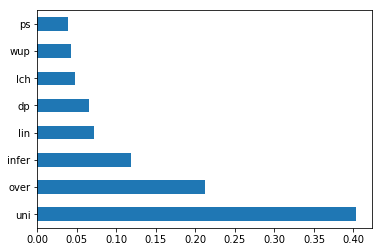

In [281]:
import matplotlib.pyplot as plt

(pd.Series(estimator_xgboost_tuning.feature_importances_, index=X.columns)
   .nlargest(10)
   .plot(kind='barh')) 
plt.show()

## Save models

In [307]:
from joblib import dump

# Save XGBoost
dump(estimator_xgboost_tuning, "estimator_xgboost_tuning.joblib.dat")

# Save lightgbm with tunning
dump(estimator_lightgbm_tuning, "estimator_lightgbm_tuning.joblib.dat")


['estimator_lightgbm_tuning.joblib.dat']

# Feature selection

Let's try to select a subset of features and check if with them, the final model can be improved.


**Read models**

In [3]:
from joblib import load

estimator_lightgbm_tuning_loaded = load("estimator_lightgbm_tuning.joblib.dat")
estimator_xgboost_tuning_loaded = load("estimator_lightgbm_tuning.joblib.dat")

estimator_lightgbm_tuning_loaded

LGBMRegressor(boosting='gbdt', boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.6793822406498514, importance_type='split',
              learning_rate=0.015794729753865512, max_depth=8,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=366, n_jobs=-1, num_leaves=15, objective=None,
              random_state=41, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=0.6990593712749179, subsample_for_bin=200000,
              subsample_freq=0)

**Read training features**

In [4]:
train_load = pd.read_csv('train_features.csv')
print(len(train_load))
X_load_train = train_load.loc[:, train_load.columns != 'score']
y_load_train = train_load['score']

scaler2 = StandardScaler()
scaler2.fit(X_load_train) # This scaler will be used for testing stage too
X_load_train_scaled = scaler2.transform(X_load_train)

X_load_train.head()

2234


,ps,lch,wup,lin,dp,infer,over,uni
0,0.576236,0.478867,0.603125,0.441224,0.944957,0.958609,0.642857,0.308706
1,0.433333,0.366896,0.444444,0.280471,0.916931,0.946287,0.631579,0.121527
2,0.423077,0.371224,0.485209,0.043715,0.939007,0.938343,0.500000,0.044599
3,0.622222,0.355331,0.638889,0.333333,0.950514,0.964189,0.733333,0.394504
4,0.621759,0.593266,0.727564,0.465101,0.879717,0.913712,0.260870,0.143134


**Read testing features**

In [5]:
test_load = pd.read_csv('test_features.csv')
print(len(test_load))
X_load_test = test_load.loc[:, test_load.columns != 'score']
y_load_test = test_load['score']

X_load_test_scaled = scaler2.transform(X_load_test)

X_load_test.head()

3108


,ps,lch,wup,lin,dp,infer,over,uni
0,0.285233,0.347540,0.340741,0.231831,0.963686,0.964584,0.444444,0.132304
1,0.506706,0.588826,0.582735,0.392431,0.952877,0.946450,0.333333,-0.043764
2,0.572329,0.505012,0.626161,0.469726,0.947358,0.950543,0.709677,0.136746
3,0.485281,0.553779,0.538273,0.481043,0.940341,0.942599,0.526316,0.083767
4,0.293447,0.365735,0.379464,0.334849,0.903658,0.927247,0.421053,-0.145027


**Correlation matrix**

We have to selection those features that are not correlated and more important. Similarly, remove those highly correlated and less important.



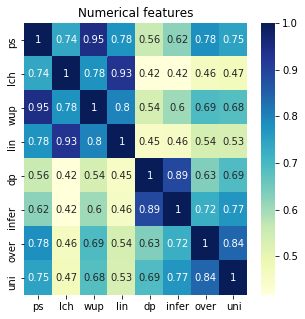

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

f = plt.figure(figsize=(5, 5))
corr = X_load_train.corr(method='pearson')

plt.title('Numerical features')
sns.heatmap(corr, annot=True, cmap="YlGnBu")
plt.show();

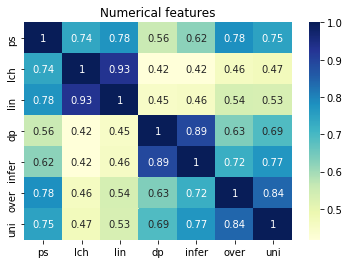

In [7]:
feats_to_remove = ['wup']
X_train_reduced = X_load_train[[c for c in list(X_load_train.columns) 
                          if c not in feats_to_remove]]
corr = X_train_reduced.corr(method='pearson')

plt.title('Numerical features')
sns.heatmap(corr, annot=True, cmap="YlGnBu")
plt.show();

In [298]:
X_load_train_reduced_scaled = X_load_train_scaled[:, 1:]

estimator_lightgbm_tuning_loaded.fit(X_load_train_reduced_scaled, y_load_train.values )



LGBMRegressor(boosting='gbdt', boosting_type='gbdt', class_weight=None,
       colsample_bytree=0.6793822406498514, importance_type='split',
       learning_rate=0.015794729753865512, max_depth=8,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=366, n_jobs=-1, num_leaves=15, objective=None,
       random_state=41, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=0.6990593712749179, subsample_for_bin=200000,
       subsample_freq=0)

In [299]:
X_load_test_reduced_scaled = X_load_test_scaled[:, 1:]
y_pred2 = estimator_lightgbm_tuning_loaded.predict(X_load_test_reduced_scaled)


print(f'Pearson correlation: {pearsonr(y_load_test.values, y_pred2)[0]}')

Pearson correlation: 0.755302792152225


The selection did not improve the overall score, due to the lack of features (only 8).

## Boruta

Let's confirm the selection with boruta. It says that all the features have to be kept

Reference:

https://github.com/scikit-learn-contrib/boruta_py

In [62]:
from boruta import BorutaPy
 
seed = 41
# Random Forests for Boruta 
rf_boruta = RandomForestRegressor(n_jobs=-1, random_state=seed)
# Perform Boruta
boruta = BorutaPy(rf_boruta, n_estimators='auto', verbose=1)
boruta.fit(X_load_train_scaled, y_load_train)
 
boruta.support_

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	8
Tentative: 	0
Rejected: 	0


array([ True,  True,  True,  True,  True,  True,  True,  True])

## Stacking and Blending

In this section we will stack the best two models to see if both joined model can outperforme them individually. Then, we will blend the predictions of this stacked estimator (blending) to create a new feature, then evaluate again.

**Stacking**

In [0]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV, RANSACRegressor
from sklearn.svm import SVR

# estimators = [
#     ('Random Forest', RandomForestRegressor(random_state=42)),
#     ('Lasso', LassoCV()),
#     ('Gradient Boosting', HistGradientBoostingRegressor(random_state=0))
# ]
estimators = [
    ('XGBoost', estimator_xgboost_tuning_loaded),
    ('LightGBM', estimator_lightgbm_tuning_loaded,
    ('Lasso', RANSACRegressor()))
]
stacking_regressor = StackingRegressor(
    estimators=estimators, final_estimator=RidgeCV()
)

In [87]:
stacking_regressor.fit(X_load_train_scaled, y_load_train)
y_pred_stacking = stacking_regressor.predict(X_load_test_scaled)

print(f'Pearson correlation: {pearsonr(y_load_test.values, y_pred_stacking)[0]}')

Pearson correlation: 0.7593424434753651


**Blending**

Added a new feature from the predictions of the stacked model, did not help. It overfitted the model.

In [0]:
blend_train = stacking_regressor.predict(X_load_train_scaled)
blend_test = stacking_regressor.predict(X_load_test_scaled)

In [0]:
X_train_blend = np.column_stack((X_load_train_scaled, blend_train))
X_test_blend = np.column_stack((X_load_test_scaled, blend_test))

In [90]:
# Fit model
stacking_regressor.fit(X_train_blend, y_load_train)

# Predict
y_pred_final = stacking_regressor.predict(X_test_blend)

print(f'Pearson correlation: {pearsonr(y_load_test.values, y_pred_final)[0]}')

Pearson correlation: 0.7476401538226516


# Conclusions







- Final pearson score (stacked model): **0.759342**
- 